# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/ALU-Course_Documents/Machine learning Techniques/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ALU-Course_Documents/Machine learning Techniques/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure by previewing the first 5 rows of the dataset,
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
# Displaying all columns of the dataset and describing the datatypes of each column
print("\nColumn Information:")
train.info()
print("\n \nData Types:")
print(train.dtypes)
print("\n \nDataset Columns")
train.columns


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB

 
Data Types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype:

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

In [7]:
# Display descriptive statistics of the training data to understand the distribution of numerical features
print("\nDescriptive Statistics:")
display(train.describe())


Descriptive Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


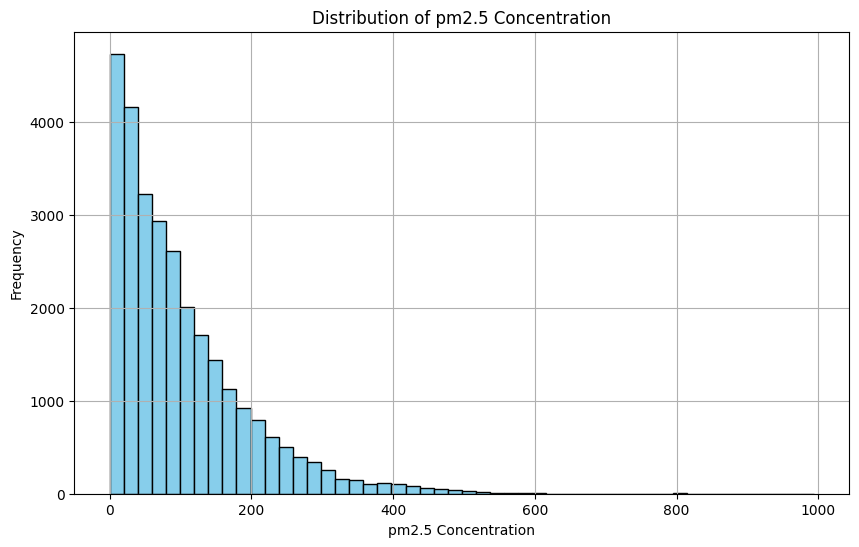

In [8]:
# Visualize the distribution of the target variable 'pm2.5'
plt.figure(figsize=(10, 6))
plt.hist(train['pm2.5'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of pm2.5 Concentration')
plt.xlabel('pm2.5 Concentration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

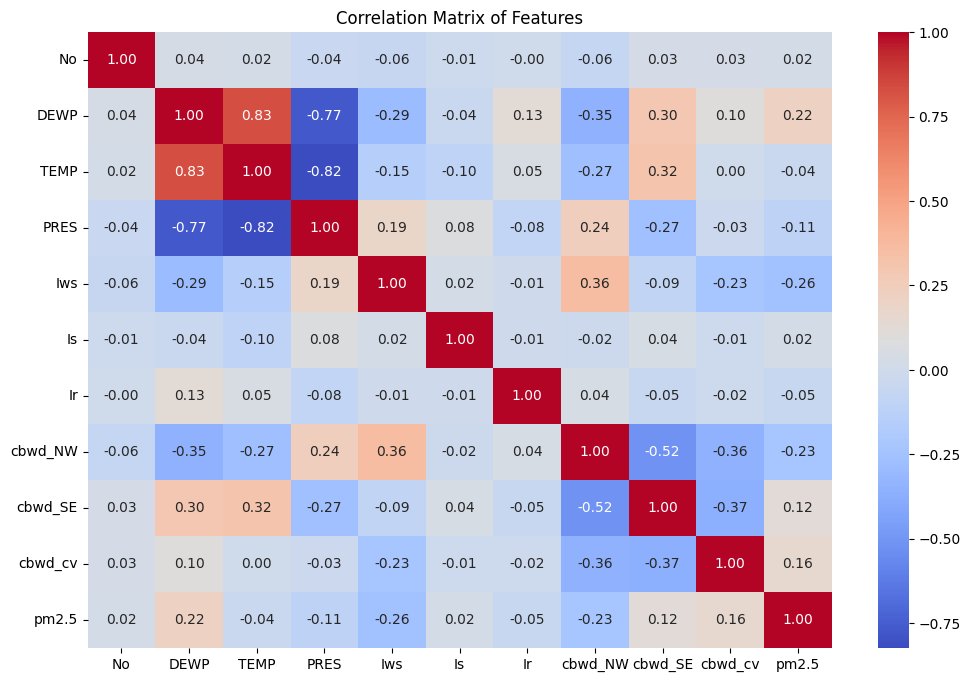

In [9]:
# Visualize the correlation matrix to understand relationships between features
import seaborn as sns

plt.figure(figsize=(12, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

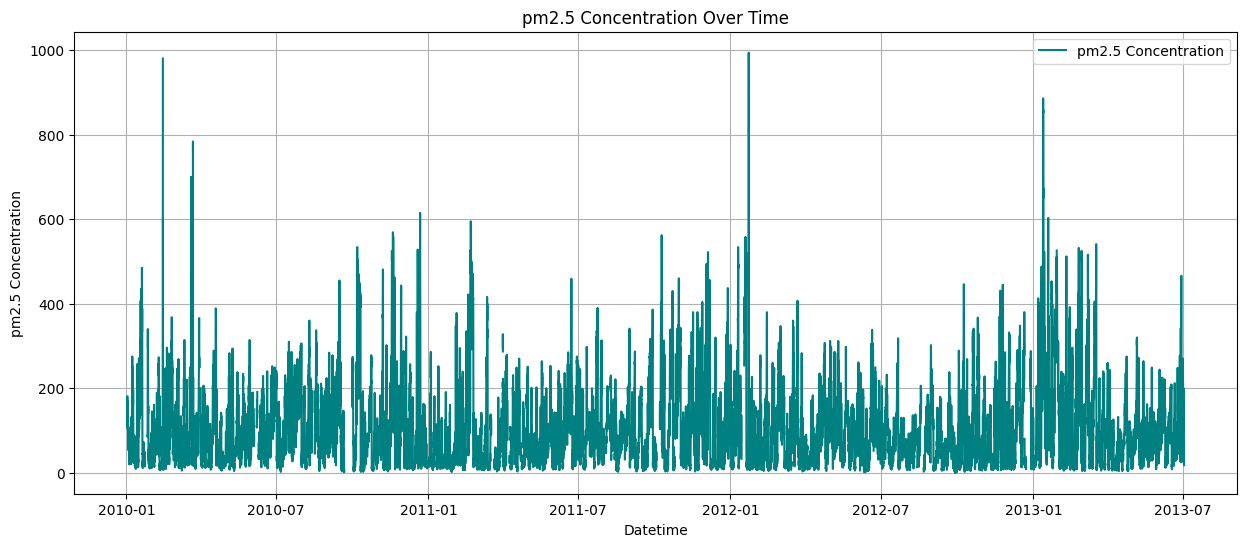

In [10]:
# Visualize the time series of 'pm2.5' concentration
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['pm2.5'], color='teal', label='pm2.5 Concentration')
plt.title('pm2.5 Concentration Over Time')
plt.xlabel('Datetime')
plt.ylabel('pm2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Attempt to automatically identify timestamp and target columns
timestamp_column = None
target_column = None

# Check for a column with 'datetime' in its name and datetime dtype
for col in train.columns:
    if 'datetime' in col.lower() or train[col].dtype == 'datetime64[ns]':
        timestamp_column = col
        break

# Check for a 'pm2.5' column or a column with 'pm2.5' or 'target' in its name and numeric dtype
for col in train.columns:
    if col.lower() == 'pm2.5' or ('pm2.5' in col.lower() or 'target' in col.lower()) and pd.api.types.is_numeric_dtype(train[col]):
        target_column = col
        break

if timestamp_column and target_column:
    print(f"Identified timestamp column: {timestamp_column}")
    print(f"Identified target column: {target_column}")

    # Set the timestamp column as index if it's not already
    if train.index.name != timestamp_column:
        train.set_index(timestamp_column, inplace=True)

    # Simple time-series plot of the target column
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train[target_column], color='teal', label=target_column)
    plt.title(f'{target_column} Over Time')
    plt.xlabel('Datetime')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()
elif target_column:
    print(f"Identified target column: {target_column}")
    print("No clear timestamp column found, skipping time-series plot.")
elif timestamp_column:
    print(f"Identified timestamp column: {timestamp_column}")
    print("No target column ('pm2.5' or 'target') found, skipping time-series plot.")
else:
    print("Could not automatically identify timestamp or target columns.")

Identified target column: pm2.5
No clear timestamp column found, skipping time-series plot.


# Handle missing values and Data preprocessing


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

here we used forward fill and backward fill to fix missing values after preprocessing data by extracting time-based features, creating cyclical features for time for both test and train data

In [13]:
# Data preprocessing function
def preprocess_data(df, target_col='pm2.5', is_train=True):
    df = df.copy()

    # Drop the 'No' column as it's just an index
    if 'No' in df.columns:
        df.drop('No', axis=1, inplace=True)

    # For training data, handle missing values in target
    if is_train and target_col in df.columns:
        # Forward fill then backward fill for pm2.5
        df[target_col] = df[target_col].fillna(method='ffill').fillna(method='bfill')

    # Extract time-based features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Create cyclical features for time
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Drop original time columns
    df.drop(['hour', 'day', 'month', 'dayofweek'], axis=1, inplace=True)

    return df

In [14]:
# Preprocess train and test data
train_processed = preprocess_data(train, is_train=True)
test_processed = preprocess_data(test, is_train=False)

In [15]:
# Handle missing values in features (forward fill)
train_processed = train_processed.fillna(method='ffill').fillna(method='bfill')
test_processed = test_processed.fillna(method='ffill').fillna(method='bfill')

In [18]:
print('\nMissing values in features:')
print(" \n\nTrain processed")
train_processed.isna().sum().sort_values(ascending=False).head(20)


Missing values in features:
 

Train processed


,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0
pm2.5,0


In [19]:
print(" \n\nTest processed missing values ")
test_processed.isna().sum().sort_values(ascending=False).head(20)

 

Test processed missing values 


,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0
is_weekend,0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

Successfully separated features and target, scaled features and target using StandardScaler, and created sequences for LSTM and split data into train and validation sets

In [20]:
# Separate features and target
X_train = train_processed.drop('pm2.5', axis=1)
y_train = train_processed['pm2.5']

X_test = test_processed.copy()

In [21]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [23]:
# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

In [24]:
# Create sequences for training
time_steps = 24  # Use 24 hours of historical data
X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)

In [25]:
# Split into train and validation sets
split_idx = int(0.9 * len(X_seq))

X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [29]:
#Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001),
                     input_shape=input_shape),

        LSTM(32, kernel_regularizer=l2(0.0001)),

        Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adagrad(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [30]:
# Build model
model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,313 (130.13 KB)

 Trainable params: 33,313 (130.13 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [32]:
# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=70,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0075 - mae: 0.7483

432/432 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 1.0075 - mae: 0.7483 - val_loss: 0.8060 - val_mae: 0.6555 - learning_rate: 0.0010
Epoch 2/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9186 - mae: 0.6885

432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.9186 - mae: 0.6885 - val_loss: 0.7401 - val_mae: 0.6143 - learning_rate: 0.0010
Epoch 3/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8720 - mae: 0.6416

432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.8717 - mae: 0.6415 - val_loss: 0.6848 - val_mae: 0.5838 - learning_rate: 0.0010
Epoch 4/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7610 - mae: 0.5983

432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.7610 - mae: 0.5983 - val_loss: 0.6465 - val_mae: 0.5642 - learning_rate: 0.0010
Epoch 5/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7051 - mae: 0.5763

432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.7051 - mae: 0.5763 - val_loss: 0.6183 - val_mae: 0.5573 - learning_rate: 0.0010
Epoch 6/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6783 - mae: 0.5627

432/432 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 0.6783 - mae: 0.5627 - val_loss: 0.5996 - val_mae: 0.5508 - learning_rate: 0.0010
Epoch 7/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6752 - mae: 0.5552

432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.6751 - mae: 0.5551 - val_loss: 0.5817 - val_mae: 0.5463 - learning_rate: 0.0010
Epoch 8/70
430/432 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6219 - mae: 0.5385

432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.6220 - mae: 0.5385 - val_loss: 0.5675 - val_mae: 0.5394 - learning_rate: 0.0010
Epoch 9/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6218 - mae: 0.5356

432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.6218 - mae: 0.5356 - val_loss: 0.5564 - val_mae: 0.5355 - learning_rate: 0.0010
Epoch 10/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6153 - mae: 0.5334

432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.6153 - mae: 0.5334 - val_loss: 0.5506 - val_mae: 0.5342 - learning_rate: 0.0010
Epoch 11/70
430/432 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5874 - mae: 0.5226

432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.5874 - mae: 0.5226 - val_loss: 0.5380 - val_mae: 0.5279 - learning_rate: 0.0010
Epoch 12/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5493 - mae: 0.5069

432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.5495 - mae: 0.5069 - val_loss: 0.5309 - val_mae: 0.5236 - learning_rate: 0.0010
Epoch 13/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5831 - mae: 0.5174

432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.5831 - mae: 0.5174 - val_loss: 0.5277 - val_mae: 0.5223 - learning_rate: 0.0010
Epoch 14/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5687 - mae: 0.5092

432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.5686 - mae: 0.5092 - val_loss: 0.5220 - val_mae: 0.5199 - learning_rate: 0.0010
Epoch 15/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5502 - mae: 0.5070

432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.5502 - mae: 0.5070 - val_loss: 0.5154 - val_mae: 0.5169 - learning_rate: 0.0010
Epoch 16/70
430/432 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5532 - mae: 0.5073

432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.5533 - mae: 0.5073 - val_loss: 0.5152 - val_mae: 0.5158 - learning_rate: 0.0010
Epoch 17/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5471 - mae: 0.5065

432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.5471 - mae: 0.5065 - val_loss: 0.5115 - val_mae: 0.5146 - learning_rate: 0.0010
Epoch 18/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5397 - mae: 0.4972

432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.5397 - mae: 0.4972 - val_loss: 0.5076 - val_mae: 0.5113 - learning_rate: 0.0010
Epoch 19/70
431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5439 - mae: 0.5004

432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.5439 - mae: 0.5004 - val_loss: 0.5074 - val_mae: 0.5113 - learning_rate: 0.0010
Epoch 20/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.5406 - mae: 0.5000 - val_loss: 0.5142 - val_mae: 0.5144 - learning_rate: 0.0010
Epoch 21/70
430/432 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5508 - mae: 0.4962

432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.5507 - mae: 0.4962 - val_loss: 0.5057 - val_mae: 0.5087 - learning_rate: 0.0010
Epoch 22/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.5315 - mae: 0.4925 - val_loss: 0.5061 - val_mae: 0.5088 - learning_rate: 0.0010
Epoch 23/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5276 - mae: 0.4871

432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.5276 - mae: 0.4871 - val_loss: 0.4975 - val_mae: 0.5056 - learning_rate: 0.0010
Epoch 24/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.5245 - mae: 0.4889 - val_loss: 0.5028 - val_mae: 0.5064 - learning_rate: 0.0010
Epoch 25/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.5257 - mae: 0.4899 - val_loss: 0.5040 - val_mae: 0.5067 - learning_rate: 0.0010
Epoch 26/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.5220 - mae: 0.4857 - val_loss: 0.4999 - val_mae: 0.5063 - learning_rate: 0.0010
Epoch 27/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.5021 - mae: 0.4778 - val_loss: 0.5023 - val_mae: 0.5049 - learning_rate: 0.0010
Epoch 28/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.5012 - mae: 0.4831 - val_loss: 0.5003 - val_mae: 0.5045 - learning_rate: 0.0010
Epoch 29/70
432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.5056 - mae: 0.4839 - val_loss: 0.4993 - val_mae: 0.5041 - learning_rate: 5.00

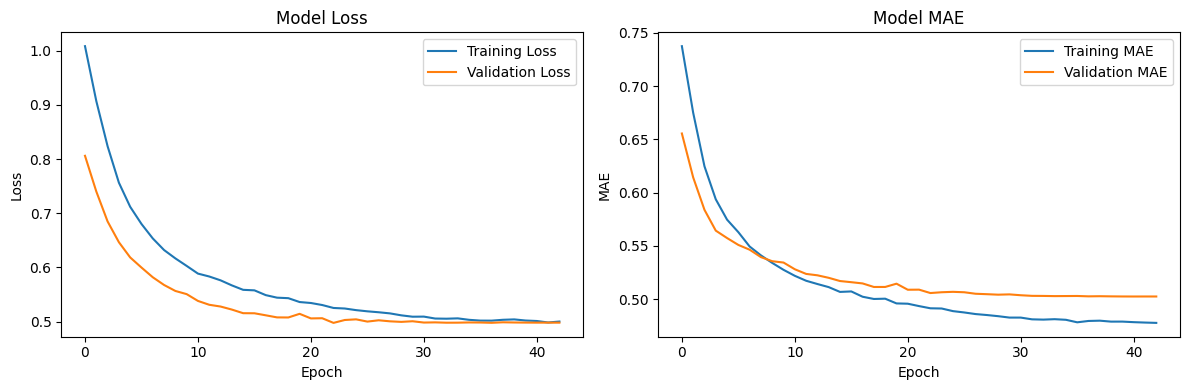

In [33]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()



863/863 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


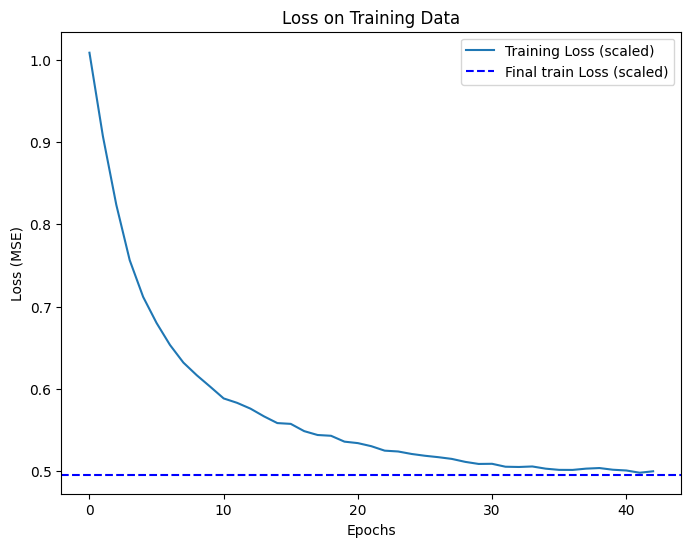

Final Training Loss (MSE) on original scale: 4204.303420844748


In [41]:
# Calculate training loss
train_predictions_scaled = model.predict(X_train_seq)
train_loss_scaled = np.mean((y_train_seq - train_predictions_scaled.flatten())**2)

# Inverse transform predictions to original scale for plotting purposes
train_predictions = target_scaler.inverse_transform(train_predictions_scaled).flatten()

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss (scaled)')  # Training loss during epochs (scaled)
plt.axhline(y=train_loss_scaled, color='blue', linestyle='--', label='Final train Loss (scaled)')  # Final training loss (scaled)
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Calculate and print the final training loss on the original scale
# Adjust slicing of y_train to match the shape of train_predictions
final_train_loss_original_scale = np.mean((y_train[time_steps:][:len(train_predictions)] - train_predictions)**2)
print(f"Final Training Loss (MSE) on original scale: {final_train_loss_original_scale}")

In [34]:
# Prepare test data for prediction
def prepare_test_data(X_train_scaled, X_test_scaled, time_steps):
    # Use the last time_steps from training data to start predictions
    last_sequence = X_train_scaled[-time_steps:]

    X_test_seq = []
    current_sequence = last_sequence.copy()

    for i in range(len(X_test_scaled)):
        # Update the sequence with new test data
        if i > 0:
            current_sequence = np.vstack([current_sequence[1:], X_test_scaled[i-1].reshape(1, -1)])

        X_test_seq.append(current_sequence)

    return np.array(X_test_seq)

In [35]:
# Create test sequences
X_test_seq = prepare_test_data(X_train_scaled, X_test_scaled, time_steps)

In [36]:
# Make predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [38]:
# Create submission file with the correct format for 'row ID'
submission_df = pd.DataFrame({
    'row ID': pd.to_datetime(test_processed.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': y_pred
})

# Ensure no negative values
submission_df['pm2.5'] = submission_df['pm2.5'].clip(lower=0)

# Sort the submission by 'row ID' to match the solution file exactly
submission_df = submission_df.sort_values(by='row ID')

# Save submission
submission_df.to_csv('submission-fixed-v7.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


In [42]:
# Evaluate on validation set (for reference)
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled).flatten()
y_val_actual = target_scaler.inverse_transform(y_val_seq.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
print(f"Validation RMSE: {rmse:.4f}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Validation RMSE: 64.0591


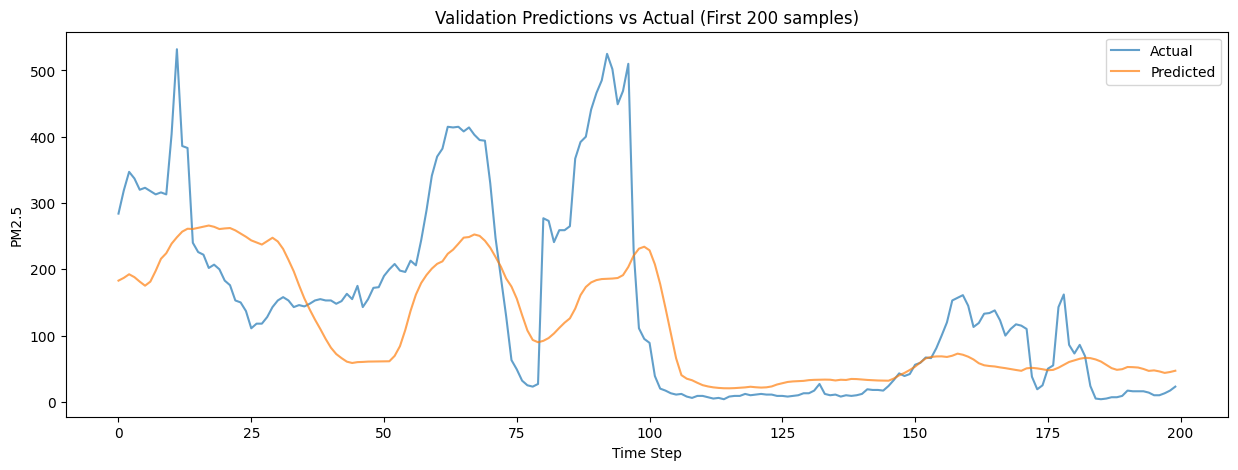

In [43]:
# Plot some predictions vs actual values
plt.figure(figsize=(15, 5))
plt.plot(y_val_actual[:200], label='Actual', alpha=0.7)
plt.plot(y_val_pred[:200], label='Predicted', alpha=0.7)
plt.title('Validation Predictions vs Actual (First 200 samples)')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.show()